# Explore feature space

## Setup

In [1]:
# import libraries
import logging
import os
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pqdm.processes import pqdm
from tqdm.notebook import tqdm

import utils

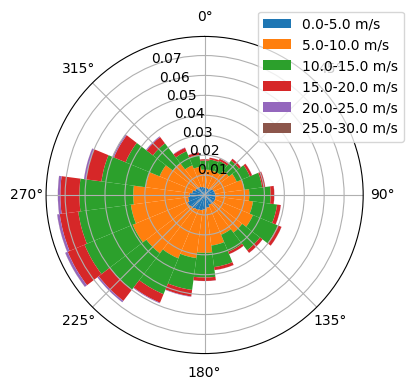

In [2]:
# visualise wind distribution
fig, ax = plt.subplots(figsize=(6, 4))
_ = utils.wfm_low.site.plot_wd_distribution(
    n_wd=len(utils.WD_DEFAULT), ws_bins=[0, 5, 10, 15, 20, 25, 30], ax=ax
)
fig.tight_layout()

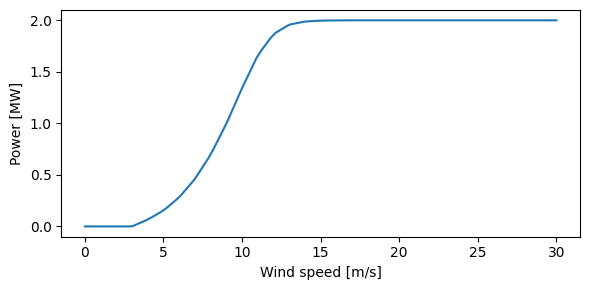

In [3]:
# visualise turbine power curve
fig, ax = plt.subplots(figsize=(6, 3))
ws = np.linspace(0, 30, 100)
ax.plot(ws, utils.wfm_low.windTurbines.power(ws) / 1e6)
ax.set_xlabel("Wind speed [m/s]")
ax.set_ylabel("Power [MW]")
fig.tight_layout()

## Baseline values

In [4]:
# run baseline simulation
sim_res_base = utils.run_sim()

In [5]:
# ensure probabilities (wind direction and speed) total 1
Sector_frequency = sim_res_base.Sector_frequency
if not np.isclose(Sector_frequency.sum(), 1):
    logging.warning(
        f"Sector frequency renormalised as total probability was {Sector_frequency.sum().values}"
    )
    Sector_frequency = Sector_frequency / Sector_frequency.sum()
P = sim_res_base.P
if not np.isclose(P.sum(), 1):
    logging.warning(f"P renormalised as total probability was {P.sum().values}")
    P = P / P.sum()

In [6]:
# calculate baseline metrics
_ = utils.calc_metrics(
    sim_res=sim_res_base,
    sim_res_base=sim_res_base,
    Sector_frequency=Sector_frequency,
    P=P,
    show=True,
)

AEP [GWh]: 79.174
LCoE [USD/MWh]: 44.477
Capacity factor [%]: 50.177


## Assess across coarse range of yaw combinations for all turbines

In [7]:
coarse_dir = os.path.join("data", "coarse_sweep.h5")
yaw_ind_coarse = {f"yaw_{i}": [-5, 0, 5] for i in sim_res_base.wt.values}
if os.path.isfile(coarse_dir):
    # load pre-existing dataset
    ds_coarse = xr.open_dataset(coarse_dir)
else:
    # initialise dataset
    nt = len(sim_res_base.wt)
    power_installed = (
        sim_res_base.windFarmModel.windTurbines.powerCtFunction.power_ct_tab[0].max()
        / 1e9
        * nt
    )
    ds_coarse = xr.Dataset(
        data_vars={
            "lcoe": (
                ["wt", "wd"] + list(yaw_ind_coarse.keys()),
                np.zeros(
                    (nt, len(sim_res_base.wd))
                    + tuple(len(x) for x in yaw_ind_coarse.values())
                ),
            ),
            "cap_fac": (
                ["wt", "wd"] + list(yaw_ind_coarse.keys()),
                np.zeros(
                    (nt, len(sim_res_base.wd))
                    + tuple(len(x) for x in yaw_ind_coarse.values())
                ),
            ),
            "aep": (
                ["wt", "wd"] + list(yaw_ind_coarse.keys()),
                np.zeros(
                    (nt, len(sim_res_base.wd))
                    + tuple(len(x) for x in yaw_ind_coarse.values())
                ),
            ),
        },
        coords={"wt": list(sim_res_base.wt.values), "wd": list(sim_res_base.wd.values)}
        | yaw_ind_coarse,
    )
    # calculate across full range of options
    yaw_options_coarse = list(product(*yaw_ind_coarse.values()))
    simulations = {
        k: v
        for k, v in zip(
            yaw_options_coarse,
            pqdm(
                [
                    {
                        "sim_res_base": sim_res_base,
                        "Sector_frequency": Sector_frequency,
                        "P": P,
                        "yaw": x,
                    }
                    for x in yaw_options_coarse
                ],
                utils.run_sim_and_calculate_metrics,
                n_jobs=int(0.75 * os.cpu_count()),
                argument_type="kwargs",
            ),
        )
    }
    # save results to dataset
    for yaw_option, (aep, lcoe, cap_fac) in tqdm(
        simulations.items(), total=len(simulations), desc="Saving values to dataset"
    ):
        ds_coarse["lcoe"].loc[:, :, *yaw_option] = lcoe
        ds_coarse["cap_fac"].loc[:, :, *yaw_option] = cap_fac
        ds_coarse["aep"].loc[:, :, *yaw_option] = aep
    # save file
    ds_coarse.to_netcdf(coarse_dir)
# aggregate over dimensions
(
    ds_coarse["lcoe_direction"],
    ds_coarse["cap_fac_direction"],
    ds_coarse["lcoe_overall"],
    ds_coarse["cap_fac_overall"],
) = utils.aggregate_metrics(
    ds_coarse.aep, ds_coarse.lcoe, ds_coarse.cap_fac, Sector_frequency
)

In [8]:
# identify optimums for each wind direction
yaw_opt_coarse = ds_coarse.lcoe_direction.stack(
    dimensions={"all_dims": yaw_ind_coarse.keys()}
).idxmin(dim="all_dims")
yaw_opt_coarse

<xarray.DataArray 'all_dims' (wd: 24)>
array([(5, 5, 0, 5, 5, 0, 5, 5, 0), (0, 0, 0, -5, 0, 0, -5, 0, 0),
       (0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 5, 5, 0, 5, 5, 0),
       (0, 0, 0, 0, 0, 0, -5, -5, 0), (0, 0, 0, 0, 0, 0, 0, 0, 0),
       (0, 0, 0, 0, 0, 0, -5, 5, 5), (0, 0, 0, 0, 0, 0, 0, 0, 0),
       (0, 0, 0, 0, 0, 0, 0, 5, 5), (0, 0, 0, 0, 5, 5, 0, 5, 5),
       (0, 0, 0, 0, 0, 5, 0, 0, 5), (0, -5, -5, 0, -5, -5, 0, -5, -5),
       (0, 5, 5, 0, 5, 5, 0, 5, 5), (0, 0, -5, 0, 0, -5, 0, 0, 0),
       (0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 5, 5, 0, 5, 5, 0, 0, 0),
       (0, -5, -5, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0, 0, 0),
       (5, 5, 5, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0, 0, 0),
       (5, 5, 0, 0, 0, 0, 0, 0, 0), (5, 5, 0, 5, 5, 0, 0, 0, 0),
       (5, 0, 0, 5, 0, 0, 0, 0, 0), (-5, -5, 0, -5, -5, 0, -5, -5, 0)],
      dtype=object)
Coordinates:
    yaw_0    (wd) int64 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 5 5 5 -5
    yaw_1    (wd) int64 5 0 0 0 0 0 0 0 0 0 0 -5 5 0 0 5 -5 0 5 0 5 5 0 -5
    yaw_2    (wd) int64 0 0 0 0 0 0 0 0 0 0 0 -5 5 -5 0 5 -5 0 5 0 0 0 0 0
    yaw_3    (wd) int64 5 -5 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 5 -5
    yaw_4    (wd) int64 5 0 0 5 0 0 0 0 0 5 0 -5 5 0 0 5 0 0 0 0 0 5 0 -5
    yaw_5    (wd) int64 0 0 0 0 0 0 0 0 0 5 5 -5 5 -5 0 5 0 0 0 0 0 0 0 0
    yaw_6    (wd) int64 5 -5 0 5 -5 0 -5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -5
    yaw_7    (wd) int64 5 0 0 5 -5 0 5 0 5 5 0 -5 5 0 0 0 0 0 0 0 0 0 0 -5
    yaw_8    (wd) int64 0 0 0 0 0 0 5 0 5 5 5 -5 5 0 0 0 0 0 0 0 0 0 0 0
  * wd       (wd) int64 0 15 30 45 60 75 90 105 ... 255 270 285 300 315 330 345

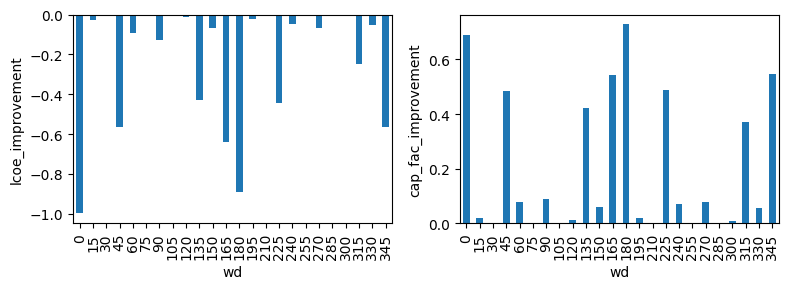

In [9]:
# plot improvements
fig, ax_all = plt.subplots(ncols=2, figsize=(8, 3))
(
    ds_coarse.lcoe_direction.min(list(yaw_ind_coarse.keys()))
    - ds_coarse.lcoe_direction.sel({k: 0 for k in yaw_ind_coarse})
).to_series().plot.bar(ax=ax_all[0])
ax_all[0].set_ylabel("lcoe_improvement")
(
    100
    * (
        ds_coarse.cap_fac_direction.max(list(yaw_ind_coarse.keys()))
        - ds_coarse.cap_fac_direction.sel({k: 0 for k in yaw_ind_coarse})
    )
).to_series().plot.bar(ax=ax_all[1])
ax_all[1].set_ylabel("cap_fac_improvement")
fig.tight_layout()

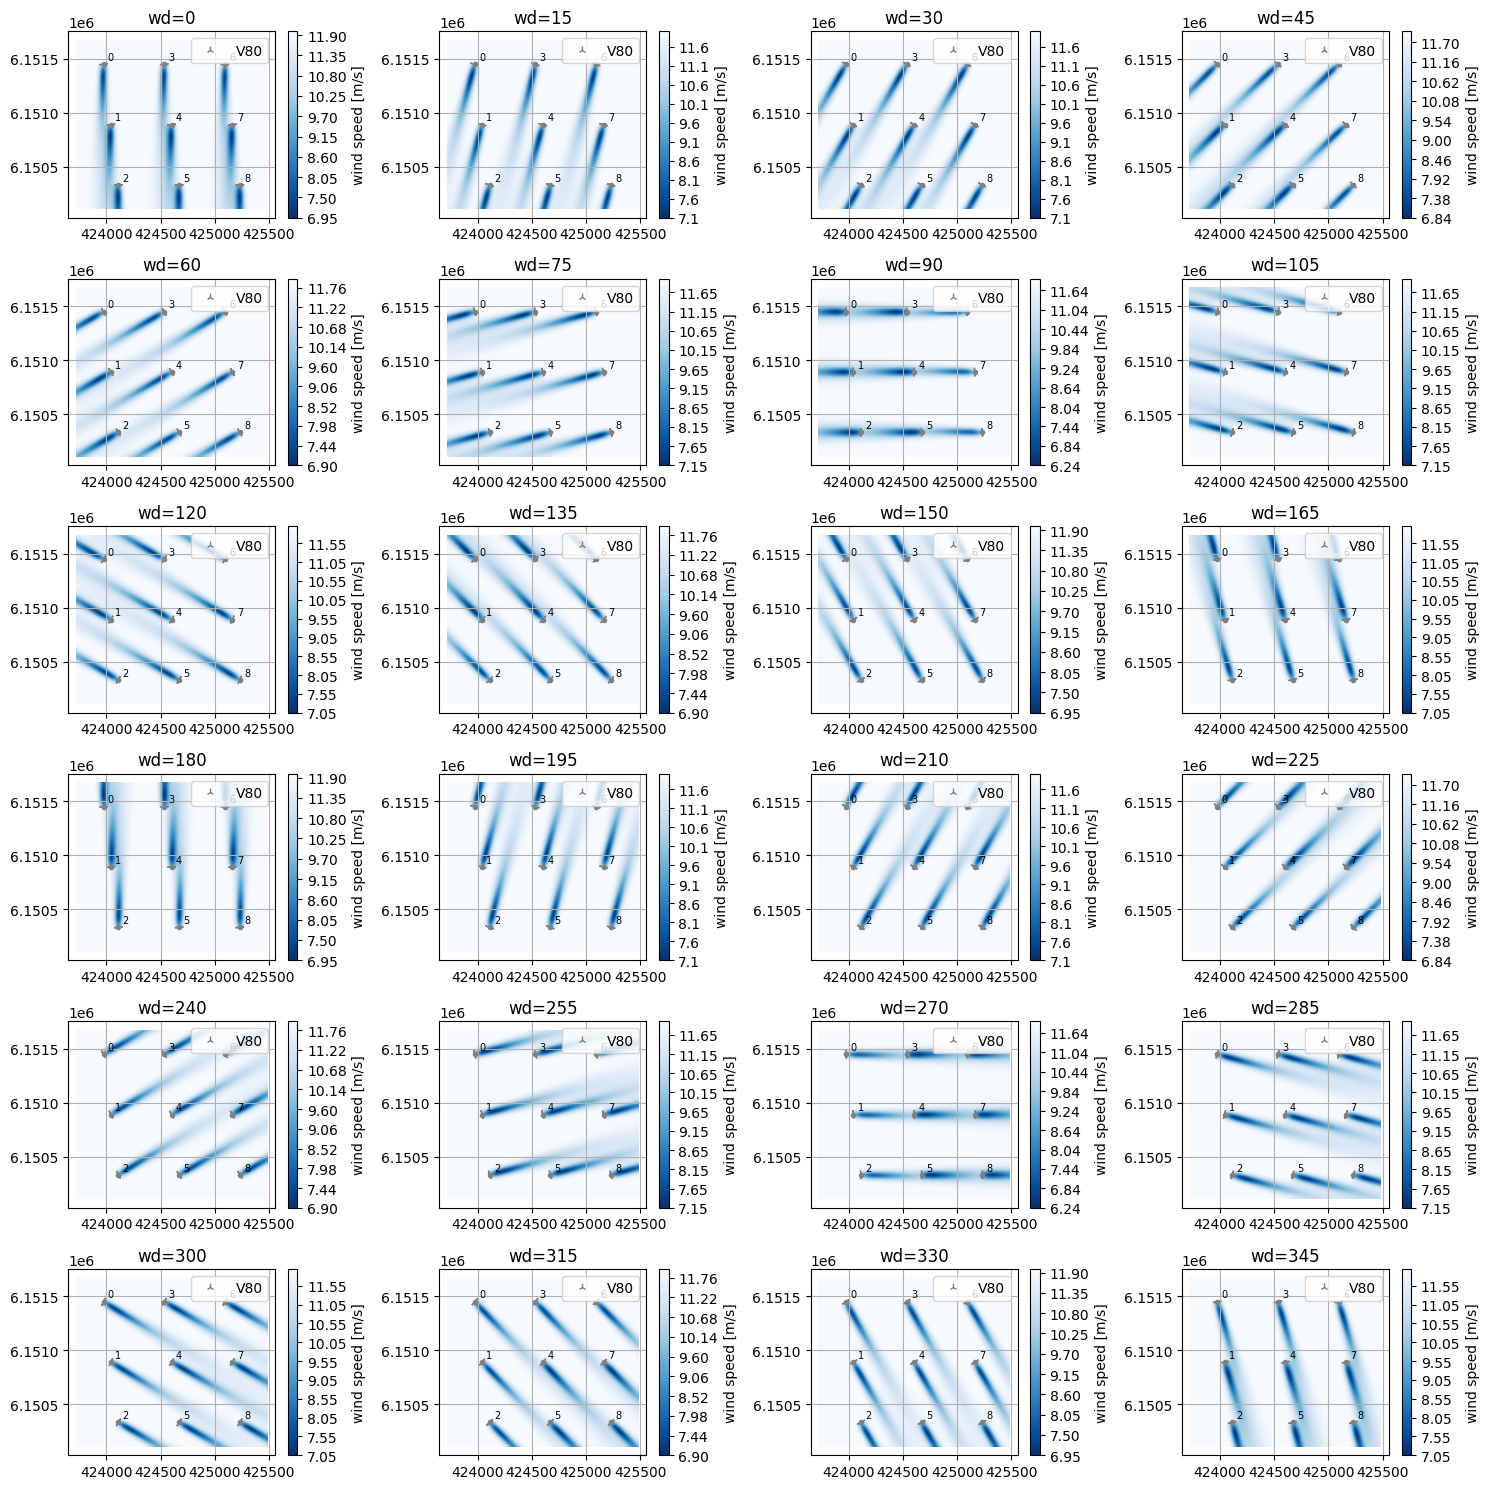

In [10]:
# plot flow maps
fig, ax_all = plt.subplots(ncols=4, nrows=6, figsize=(15, 15))
for wd, ax in zip(ds_coarse.wd.values, ax_all.flatten()):
    fm = utils.run_sim(
        yaw=yaw_opt_coarse.sel(wd=wd).values.tolist(), wd=wd, ws=12
    ).flow_map()
    fm.plot_wake_map(ax=ax)
    ax.grid()
    ax.set_title(f"wd={wd}")
fig.tight_layout()

Observations
- Improvements observied in every direction but direction with existing offset and downstream turbines near to wake benefit most as they require only a small deviation
- Movement of last front row is pointless
- Middle rows don't seem to benefit from changing (in this coarse system anyway) with no pre-existing offset

## Assess across fine range of yaw combinations for two turbines

In [11]:
fine_dir = os.path.join("data", "fine_sweep.h5")
yaw_ind_fine = {
    f"yaw_{i}": np.arange(-30, 30.5, 0.5) for i in sim_res_base.wt.values[[1, 4]]
}
if os.path.isfile(fine_dir):
    # load pre-existing dataset
    ds_fine = xr.open_dataset(fine_dir)
else:
    # initialise dataset
    nt = len(sim_res_base.wt)
    power_installed = (
        sim_res_base.windFarmModel.windTurbines.powerCtFunction.power_ct_tab[0].max()
        / 1e9
        * nt
    )
    ds_fine = xr.Dataset(
        data_vars={
            "lcoe": (
                ["wt", "wd"] + list(yaw_ind_fine.keys()),
                np.zeros(
                    (nt, len(sim_res_base.wd))
                    + tuple(len(x) for x in yaw_ind_fine.values())
                ),
            ),
            "cap_fac": (
                ["wt", "wd"] + list(yaw_ind_fine.keys()),
                np.zeros(
                    (nt, len(sim_res_base.wd))
                    + tuple(len(x) for x in yaw_ind_fine.values())
                ),
            ),
            "aep": (
                ["wt", "wd"] + list(yaw_ind_fine.keys()),
                np.zeros(
                    (nt, len(sim_res_base.wd))
                    + tuple(len(x) for x in yaw_ind_fine.values())
                ),
            ),
        },
        coords={"wt": list(sim_res_base.wt.values), "wd": list(sim_res_base.wd.values)}
        | yaw_ind_fine,
    )
    # calculate across full range of options
    yaw_options_fine = list(
        product(*[yaw_ind_fine.get(f"yaw_{x}", [0]) for x in sim_res_base.wt.values])
    )
    simulations = {
        k: v
        for k, v in zip(
            yaw_options_fine,
            pqdm(
                [
                    {
                        "sim_res_base": sim_res_base,
                        "Sector_frequency": Sector_frequency,
                        "P": P,
                        "yaw": x,
                    }
                    for x in yaw_options_fine
                ],
                utils.run_sim_and_calculate_metrics,
                n_jobs=int(0.75 * os.cpu_count()),
                argument_type="kwargs",
            ),
        )
    }
    # save results to dataset
    for yaw_option, (aep, lcoe, cap_fac) in tqdm(
        simulations.items(), total=len(simulations), desc="Saving values to dataset"
    ):
        ds_fine["lcoe"].loc[:, :, yaw_option[1], yaw_option[4]] = lcoe
        ds_fine["cap_fac"].loc[:, :, yaw_option[1], yaw_option[4]] = cap_fac
        ds_fine["aep"].loc[:, :, yaw_option[1], yaw_option[4]] = aep
    # save file
    ds_fine.to_netcdf(fine_dir)
# aggregate over dimensions
(
    ds_fine["lcoe_direction"],
    ds_fine["cap_fac_direction"],
    ds_fine["lcoe_overall"],
    ds_fine["cap_fac_overall"],
) = utils.aggregate_metrics(
    ds_fine.aep, ds_fine.lcoe, ds_fine.cap_fac, Sector_frequency
)

In [12]:
# identify optimums for each wind direction

# calculate optimum for each direction
yaw_opt_fine = ds_fine.lcoe_direction.stack(
    dimensions={"all_dims": yaw_ind_fine.keys()}
).idxmin(dim="all_dims")
# fill out 0 values for unoptimised turbines
data_list = []
for vals in yaw_opt_fine.values:
    yaw_opt = list((0,) * len(ds_fine.wt))
    yaw_opt[1], yaw_opt[4] = vals
    data_list.append(tuple(yaw_opt))
data = np.empty(len(data_list), dtype=object)
data[:] = data_list
# store as dataarray
yaw_opt_fine = xr.DataArray(data=data, coords={"wd": yaw_opt_fine.wd.values})

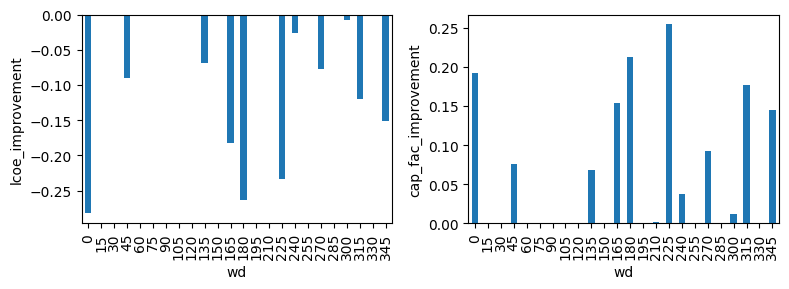

In [13]:
# plot improvements
fig, ax_all = plt.subplots(ncols=2, figsize=(8, 3))
(
    ds_fine.lcoe_direction.min(list(yaw_ind_fine.keys()))
    - ds_fine.lcoe_direction.sel(yaw_1=0, yaw_4=0)
).to_series().plot.bar(ax=ax_all[0])
ax_all[0].set_ylabel("lcoe_improvement")
(
    100
    * (
        ds_fine.cap_fac_direction.max(list(yaw_ind_fine.keys()))
        - ds_fine.cap_fac_direction.sel(yaw_1=0, yaw_4=0)
    )
).to_series().plot.bar(ax=ax_all[1])
ax_all[1].set_ylabel("cap_fac_improvement")
fig.tight_layout()

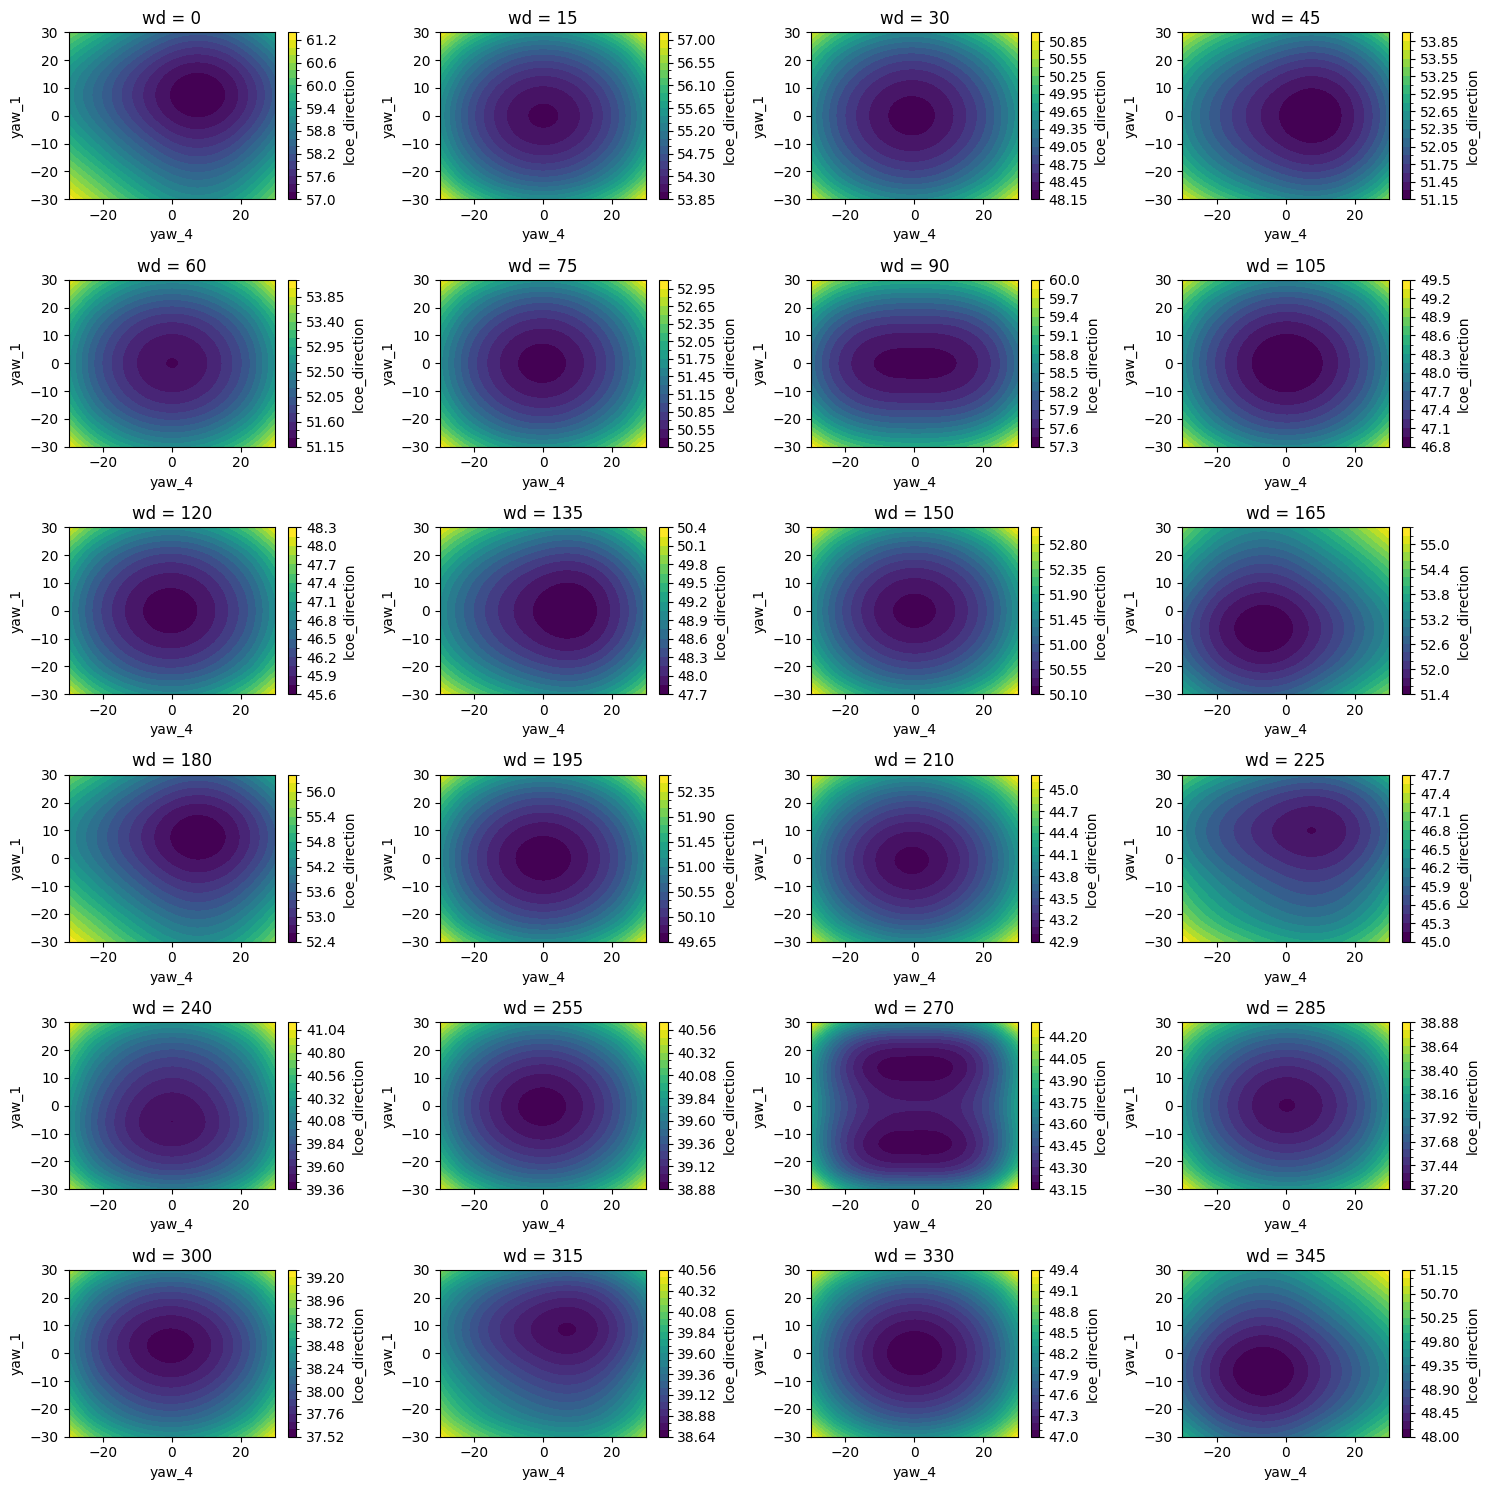

In [14]:
# plot distribution of lcoe values
fig, ax_all = plt.subplots(ncols=4, nrows=6, figsize=(15, 15))
for wd, ax in zip(ds_fine.wd, ax_all.flatten()):
    _ = ds_fine.lcoe_direction.sel(wd=wd.values).plot.contourf(levels=25, ax=ax)
fig.tight_layout()

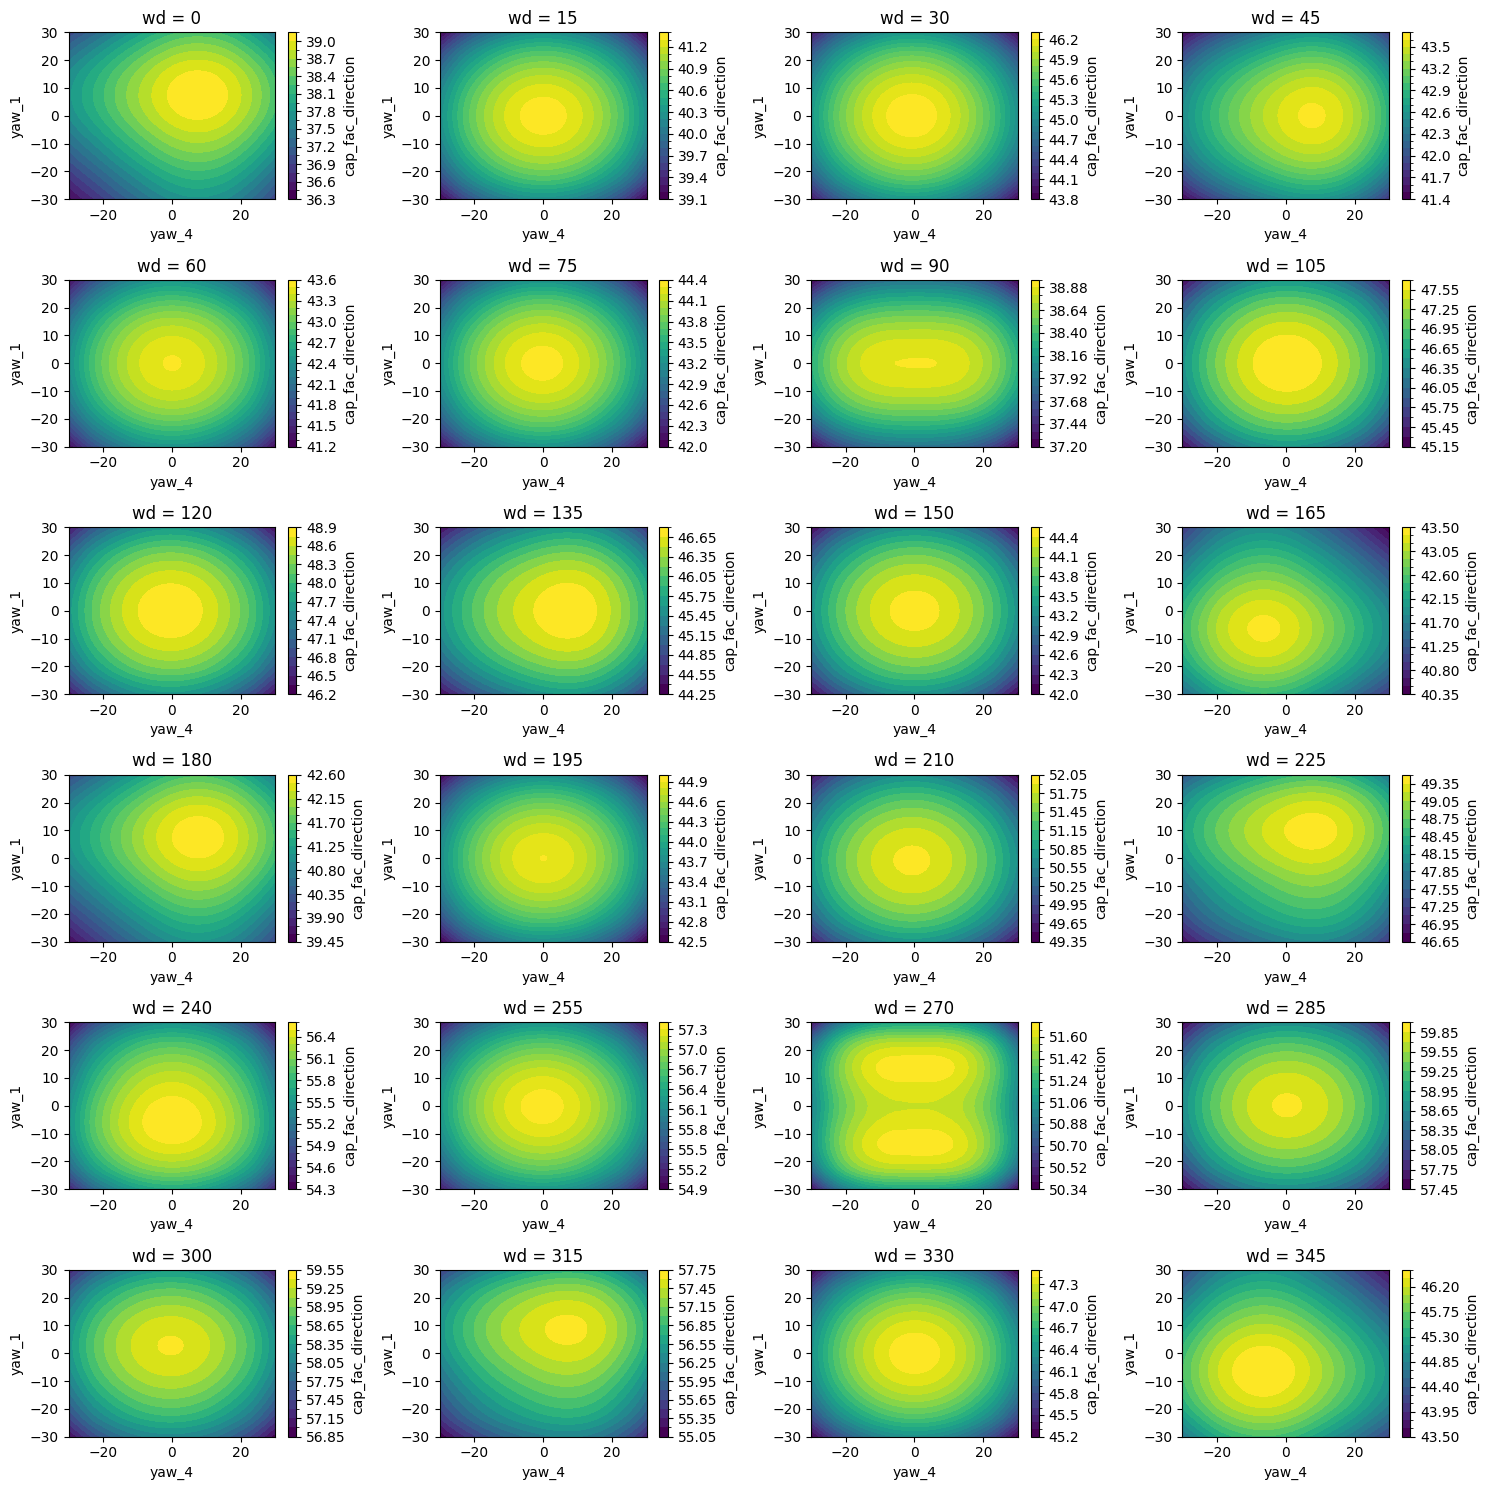

In [15]:
# plot distribution of cap_fac values
fig, ax_all = plt.subplots(ncols=4, nrows=6, figsize=(15, 15))
for wd, ax in zip(ds_fine.wd, ax_all.flatten()):
    _ = (100 * ds_fine.cap_fac_direction.sel(wd=wd.values)).plot.contourf(
        levels=25, ax=ax
    )
fig.tight_layout()

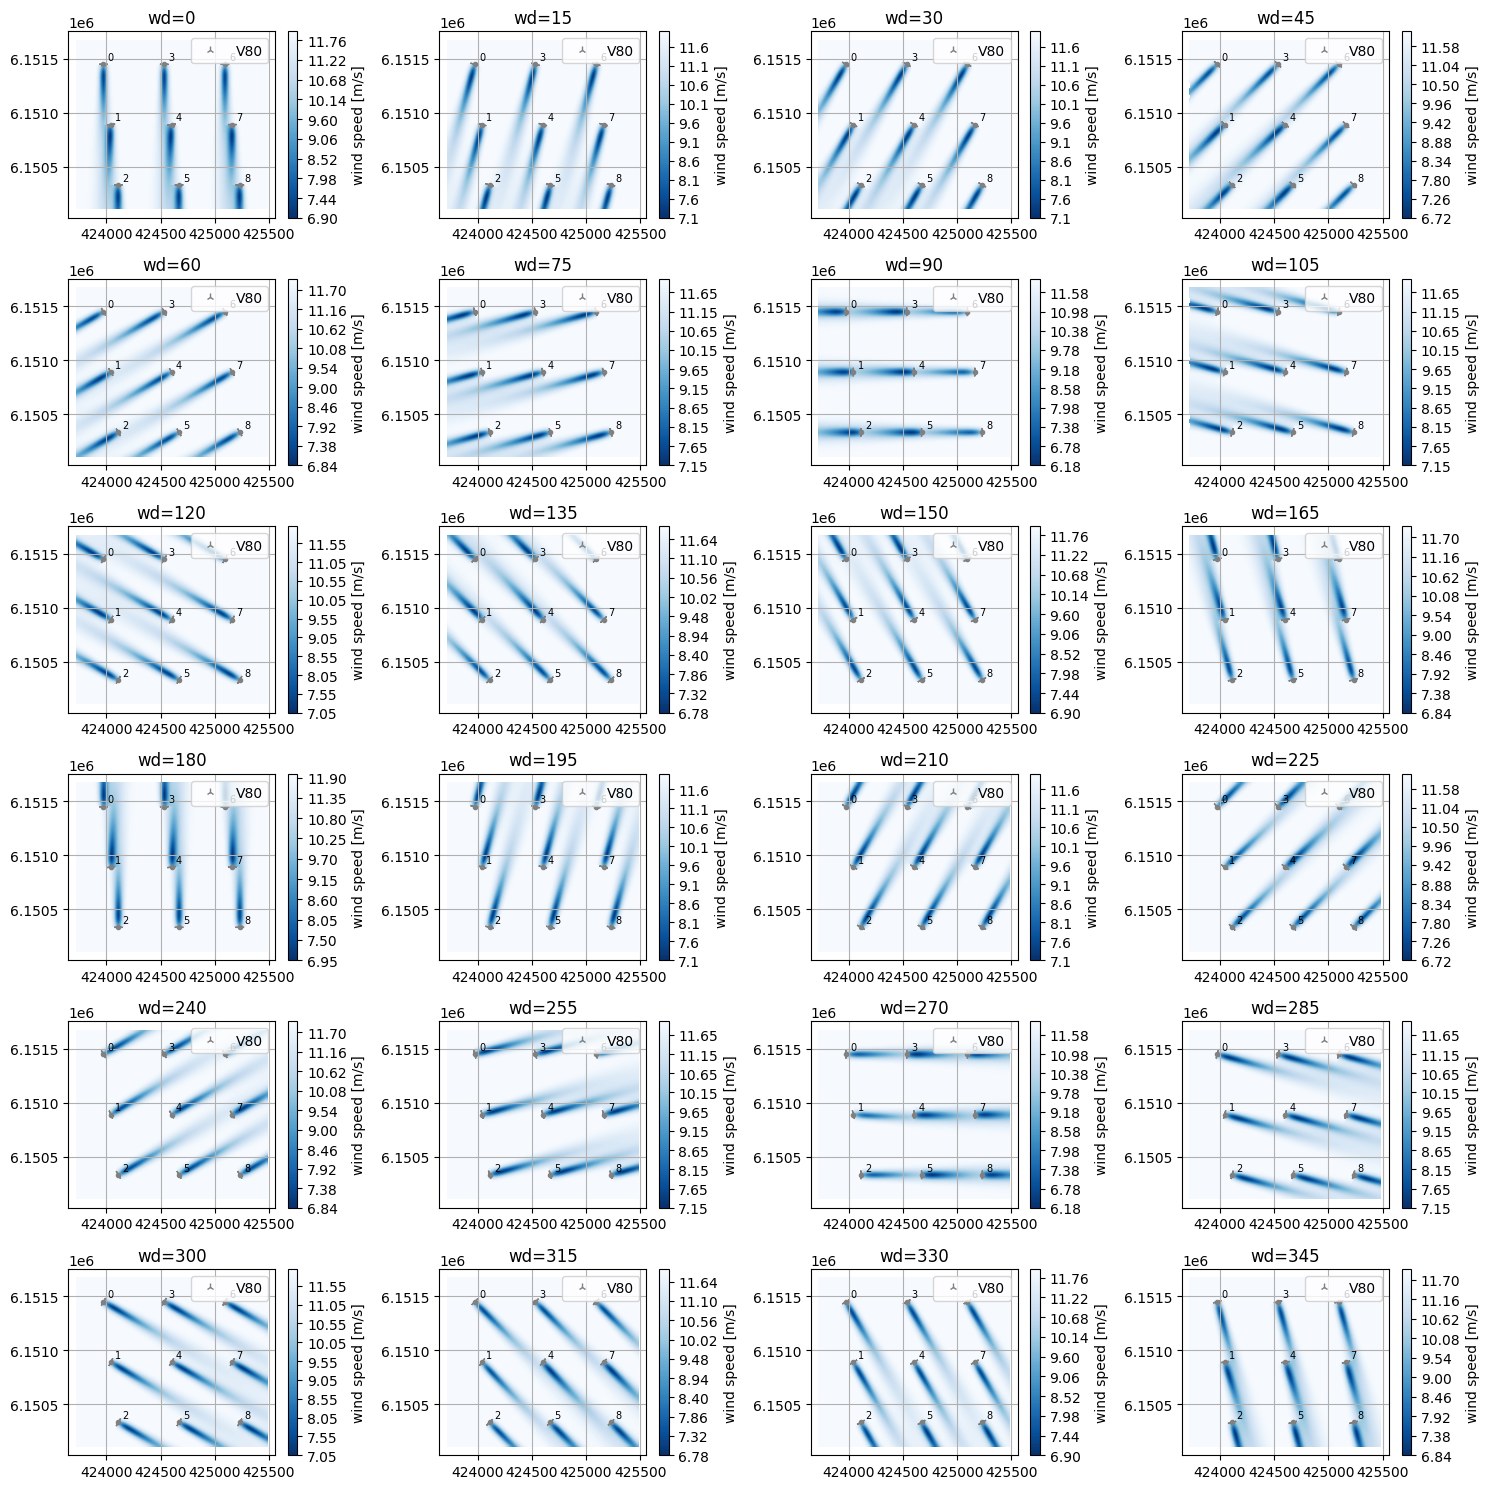

In [16]:
# plot flow maps
fig, ax_all = plt.subplots(ncols=4, nrows=6, figsize=(15, 15))
for wd, ax in zip(ds_fine.wd.values, ax_all.flatten()):
    fm = utils.run_sim(
        yaw=yaw_opt_fine.sel(wd=wd).values.tolist(), wd=wd, ws=12
    ).flow_map()
    fm.plot_wake_map(ax=ax)
    ax.grid()
    ax.set_title(f"wd={wd}")
fig.tight_layout()

[0, 7.5, 0]


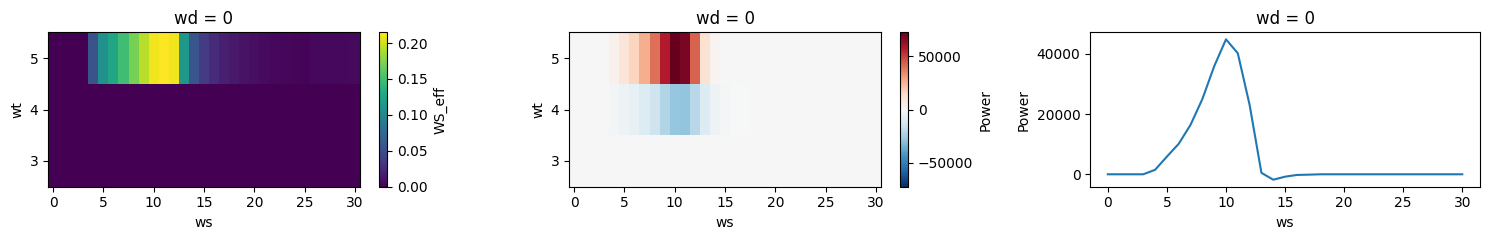

In [17]:
# plot distribution of wind speed and power changes
wd = 0
print(list(yaw_opt_fine.sel(wd=wd).values.tolist())[3:6])
sim_res_opt_fine = utils.run_sim(yaw=yaw_opt_fine.sel(wd=wd).values.tolist())
fig, ax = plt.subplots(ncols=3, figsize=(15, 2.5))
WS_eff_diff = (sim_res_opt_fine.WS_eff - sim_res_base.WS_eff).sel(
    {"wt": [3, 4, 5], "wd": wd}
)
Power_diff = (sim_res_opt_fine.Power - sim_res_base.Power).sel(
    {"wt": [3, 4, 5], "wd": wd}
)
WS_eff_diff.plot(ax=ax[0])
Power_diff.plot(ax=ax[1])
Power_diff.sum("wt").plot(ax=ax[2])
ax[0].set_yticks(WS_eff_diff.wt)
ax[1].set_yticks(Power_diff.wt)
fig.tight_layout()

Observations
- Rare for front and middle rows to be moved
- Direction of movement favours prexisting offset if one exists
- Considerable improvements observed even with diagonal wind directions which have better spacing between wakes
- Off design performance is good - not too sensitive near optimum
- Improvements increase with wind speed until maximal power output
    - Near maximal power output speed the increase of the second turbine is minimal as the power curve flattens so a net loss is observed
- Optimal yaw likely a function of wind speed and direction
    - Change with speed appears smoother than changes with direction